# Prediction stock returns with linear regression

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr #斯皮尔曼（Spearman）相关是衡量两个变量的依赖性的 非参数 指标。 它利用单调方程评价两个统计变量的相关性。 

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [4]:
YEAR = 252 #一年包含的交易日

## Load Data

In [5]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [6]:
data.index.names = ['symbol', 'date'] #给index命名

In [7]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1) #去除列名中含lag的列

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2559038 entries, ('A', Timestamp('2013-07-03 00:00:00')) to ('ZUMZ', Timestamp('2017-11-29 00:00:00'))
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   volume                 float64
 1   dollar_vol             float64
 2   dollar_vol_1m          float64
 3   dollar_vol_rank        float64
 4   rsi                    float64
 5   bb_high                float64
 6   bb_low                 float64
 7   atr                    float64
 8   macd                   float64
 9   return_1d              float64
 10  return_5d              float64
 11  return_10d             float64
 12  return_21d             float64
 13  return_42d             float64
 14  return_63d             float64
 15  target_1d              float64
 16  target_5d              float64
 17  target_10d             float64
 18  target_21d             float64
 19  year_2014              uint8  
 20  year_2015        

### Select Investment Universe

In [9]:
data = data[data.dollar_vol_rank<100]

In [10]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d    

### Create Model Data

In [11]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1) #去除y中所含的列
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1) #去除这些列

In [12]:
y

target_1d  target_5d  target_10d  target_21d
symbol date                                                    
AAL    2013-07-25   0.013808   0.005775    0.000794   -0.007255
       2013-07-26   0.007334  -0.001787   -0.002597   -0.007757
       2013-07-29  -0.001560  -0.000625   -0.002153   -0.010307
       2013-07-30   0.007813  -0.002934   -0.015880   -0.010631
       2013-07-31   0.001550  -0.005011   -0.017793   -0.009130
...                      ...        ...         ...         ...
ZTS    2014-11-28  -0.012464  -0.004265   -0.007266   -0.001703
       2014-12-01   0.008339  -0.001220   -0.006092   -0.001459
       2014-12-02   0.003129  -0.004147   -0.009055   -0.001546
       2014-12-03  -0.019608  -0.009585   -0.008687   -0.001980
       2014-12-04  -0.000455  -0.005144   -0.001949   -0.001505

[109675 rows x 4 columns]

In [13]:
X

dollar_vol_1m        rsi   bb_high    bb_low       atr  \
symbol date                                                                 
AAL    2013-07-25  223614.661574  69.669475  0.011251  0.140777 -0.383445   
       2013-07-26  234821.351626  72.045207  0.007052  0.146370 -0.412740   
       2013-07-29  243001.954091  73.259776  0.008843  0.146963 -0.494894   
       2013-07-30  243122.621493  72.532538  0.018500  0.142355 -0.565684   
       2013-07-31  256336.659780  73.926238  0.016465  0.139949 -0.653399   
...                          ...        ...       ...       ...       ...   
ZTS    2014-11-28  294715.115434  71.884144  0.043559  0.157493  0.397024   
       2014-12-01  297525.671580  67.137279  0.051976  0.131103  0.403122   
       2014-12-02  298272.515355  68.612084  0.041573  0.120638  0.323857   
       2014-12-03  295315.035852  69.175766  0.038192  0.111125  0.236555   
       2014-12-04  286390.276661  61.677853  0.051743  0.080568  0.273293   

                       macd  return_1d  return_5d  return_10d  return_21d  \
symbol date                                                                 
AAL    2013-07-25  0.681257   0.017838   0.004413    0.008103    0.006426   
       2013-07-26  0.772848   0.013808   0.009262    0.008389    0.007936   
       2013-07-29  0.854980   0.007334   0.011627    0.007984    0.007873   
       2013-07-30  0.904814  -0.001560   0.012430    0.006755    0.007476   
       2013-07-31  0.954135   0.007813   0.009025    0.004774    0.006752   
...                     ...        ...        ...         ...         ...   
ZTS    2014-11-28  2.806829   0.005820   0.008117    0.003841    0.009878   
       2014-12-01  2.691178  -0.012464   0.002269    0.002815    0.008365   
       2014-12-02  2.615256   0.008339   0.000717    0.001147    0.009064   
       2014-12-03  2.540352   0.003129   0.004380    0.001551    0.008311   
       2014-12-04  2.329735  -0.019608  -0.003018    0.001374    0.005614   

                   ...  capital_goods  consumer_non-durables  \
symbol date        ...                                         
AAL    2013-07-25  ...              0                      0   
       2013-07-26  ...              0                      0   
       2013-07-29  ...              0                      0   
       2013-07-30  ...              0                      0   
       2013-07-31  ...              0                      0   
...                ...            ...                    ...   
ZTS    2014-11-28  ...              0                      0   
       2014-12-01  ...              0                      0   
       2014-12-02  ...              0                      0   
       2014-12-03  ...              0                      0   
       2014-12-04  ...              0                      0   

                   consumer_services  energy  finance  health_care  \
symbol date                                                          
AAL    2013-07-25                  0       0        0            0   
       2013-07-26                  0       0        0            0   
       2013-07-29                  0       0        0            0   
       2013-07-30                  0       0        0            0   
       2013-07-31                  0       0        0            0   
...                              ...     ...      ...          ...   
ZTS    2014-11-28                  0       0        0            1   
       2014-12-01                  0       0        0            1   
       2014-12-02                  0       0        0            1   
       2014-12-03                  0       0        0            1   
       2014-12-04                  0       0        0            1   

                   miscellaneous  public_utilities  technology  transportation  
symbol date                                                                     
AAL    2013-07-25              0                 0           0               1  
       2013-07-26           

## Custom MultipleTimeSeriesCV

<img src='..\image\timeseriesCV.jpg'>

In [14]:
# sequential data like time series requires careful cross-validation to be set up so that we do not inadvertently introduce look-ahead bias or leakage
class MultipleTimeSeriesCV: #多重时间序列交叉验证(Cross-validating)
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self, #实例
                 n_splits=3, #窗口滚动总次数
                 train_period_length=126, 
                 test_period_length=21,
                 lookahead=None, #提前量
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    #The split() method returns a generator yielding pairs of train and test indices,
    #which we can then use to select outcomes and features.
    #The number of pairs depends on the parameter n_splits
    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique() #获取日期索引，剔除重复值
        days = sorted(unique_dates, reverse=True) #!!!倒序排列日期，这与后面倒着定义训练集，测试集的坐标相关

        split_idx = []
        
        #将n_splits次的训练集，测试集对应的时间端点保存到split_idx中
        for i in range(self.n_splits): #循环n_splits次
            test_end_idx = i * self.test_length #self.test_length默认为21，test_end_idx为21*i (i = 0,1,2)
            test_start_idx = test_end_idx + self.test_length #test_start_idx = test_end_idx + 21
            train_end_idx = test_start_idx + self.lookahead - 1 #train_end_idx = test_start_idx + self.lookahead - 1 
                #！！！加入该项的原因：在使用未来收益率时训练时，当前的部分数据包含了未来的信息
                #为了避免测试集与该信息存在交集，应当将测试集的头部向后推，从而使信息错开
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1 #train_start_idx = train_end_idx + 125 + self.lookahead
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx]) #将三次train_test对应的训练集，测试集的坐标保存到split_idx中
        
        #以时间端点为标准，对应到数据中各个symbol相应的index
        dates = X.reset_index()[['date']] #给X重设index并提取其中的日期项,dates的日期项的顺序是正的，包含了所有股票在所选时间的序列。而days则只包含了不重复的时间数据。
        for train_start, train_end, test_start, test_end in split_idx: #依次读取每次训练的days的数据坐标，注意这些坐标数据是由“远”及“近”的
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index #获取train_set的index，其由dates的index而来，因此是正序的，而且这一index的范围囊括了所有对象股
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle: #默认为False
                np.random.shuffle(list(train_idx)) #对train_idx中的项(index)进行洗牌
                
            yield train_idx, test_idx
            #yield的作用：返回一个可以用来迭代(for循环)的生成器，它的应用场景通常为一个需要返回一系列值的，含有循环的函数中

    def get_n_splits(self, X, y, groups=None): #返回n_split这个参数，即滚动窗口的次数
        return self.n_splits

### Verify that it works

In [21]:
train_period_length = 63 #自定义train_period_length的数据
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length) #n_splits为75，即窗口要滚动75次，若干测试集的时长加起来约为3年
lookahead =1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length) #创建一个CV的实例

In [22]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    print(f'{test_idx}')
    i+=1
i #i最后取值为75，说明循环进行了75次
#结果中第一列对应的Index为最后一次训练时所选训练集的index，而且这些index对应了所有的目标股

Int64Index([  1980,   1981,   1982,   1983,   1984,   1985,   1986,   1987,
              1988,   1989,
            ...
            109390, 109391, 109392, 109393, 109394, 109395, 109396, 109397,
            109398, 109399],
           dtype='int64', length=984)
Int64Index([  1970,   1971,   1972,   1973,   1974,   1975,   1976,   1977,
              1978,   1979,
            ...
            109380, 109381, 109382, 109383, 109384, 109385, 109386, 109387,
            109388, 109389],
           dtype='int64', length=983)
Int64Index([  1960,   1961,   1962,   1963,   1964,   1965,   1966,   1967,
              1968,   1969,
            ...
            109370, 109371, 109372, 109373, 109374, 109375, 109376, 109377,
            109378, 109379],
           dtype='int64', length=983)
Int64Index([   849,    850,    851,    852,    853,   1950,   1951,   1952,
              1953,   1954,
            ...
            109360, 109361, 109362, 109363, 109364, 109365, 109366, 109367,
            109

Int64Index([   346,    347,    348,    349,    350,    351,    352,    353,
               354,    355,
            ...
            108651, 108652, 108653, 108654, 108655, 108656, 108657, 108658,
            108659, 108660],
           dtype='int64', length=990)


75

In [23]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx] #利用train_idx筛选出训练集数据
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index()) #把本次循环中对应的训练集与测试集拼起来
    n = len(df)
    assert n == len(df.drop_duplicates()),'df中存在重复值，即训练集与测试集有交集' #断言可以在条件不满足程序运行的情况下直接返回错误，而不必等待程序运行后出现崩溃的情况
    print(train.groupby(level='symbol').size().value_counts().index[0], #此处的symble即为股票代码 #.size()表示在每个group中求行的个数 #.value_counts()表示求某一类行个数出现的次数 #.index[0]可以取出现次数最多的行数
          train_dates.min().date(), train_dates.max().date(), #取最小的日期与最大的日期
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10: #暂且只循环10次，因为这里只是验证函数是否可行
        break
        
#思考：为何有的股票所对应的训练集长度不为所定义的63？
#答：虽然我们选取的时间跨度共有63天，但是有的股票在这一时间跨度中存在缺失的日期，所以使其对应的数据量不足63。
#存在缺失的日期是因为在这些日期中股票的dollar volumn lm没有排进前当日的前100名

72 2017-07-21 2017-10-31 10 2017-11-15 2017-11-29
72 2017-07-07 2017-10-17 10 2017-10-31 2017-11-14
72 2017-06-22 2017-10-03 10 2017-10-17 2017-10-30
72 2017-06-08 2017-09-19 10 2017-10-03 2017-10-16
72 2017-05-24 2017-09-05 10 2017-09-19 2017-10-02
72 2017-05-10 2017-08-21 10 2017-09-05 2017-09-18
72 2017-04-26 2017-08-07 10 2017-08-21 2017-09-01
71 2017-04-12 2017-07-24 10 2017-08-07 2017-08-18
71 2017-03-29 2017-07-10 10 2017-07-24 2017-08-04
71 2017-03-15 2017-06-23 10 2017-07-10 2017-07-21


## Visualization helper functions

### Prediction vs Actual Scatter Plot

In [18]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg') #绘制双变量图
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

### Daily IC Distribution

In [19]:
#information coefficient
#绘制日频信息系数的分布
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

### Rolling Daily IC

In [20]:
#绘制IC与RMSE的滚动窗口(时长为21天)均值的时序
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

## Linear Regression with sklearn

### Set up cross-validation

In [21]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation with LinearRegression 

In [22]:
%%time
target = f'target_{lookahead}d' #lookahead被设置为1
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1): #每次循环对应一次训练
    
    # 为训练集与测试集的x,y赋值
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    
    #在训练集中进行回归，得到回归模型，并用该模型去预测测试集的结果，得到y_pred
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)
    
    #将y_test转变为DataFrame形式，并增加y_pred这一列
    preds = y_test.to_frame('actuals').assign(predicted=y_pred) #assign():增加新的一列
    preds_by_day = preds.groupby(level='date')
    
    #求该次循环中模型在测试集中的得分
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,x.actuals)[0] * 100).to_frame('ic'), 
                        #求 预测值与实际值之间的斯皮尔曼相关系数*100，取之值为IC，且IC是以日为单位计算得到的
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,y_true=x.actuals))).to_frame('rmse')], axis=1)
                        #求 均方根误差

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores) #储存着每次循环(一次循环对应一次训练)的评分数据
lr_predictions = pd.concat(lr_predictions) #储存着每次循环的预测值与真实值数据

Wall time: 15.8 s


### Persist results

In [22]:
lr_scores.to_hdf('data.h5', 'lr/scores')
lr_predictions.to_hdf('data.h5', 'lr/predictions')

In [23]:
lr_scores = pd.read_hdf('data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('data.h5', 'lr/predictions')

### Evaluate results

In [24]:
lr_predictions 
#将若干次循环的preds数据一次一次往下加，而且有过多少次循环，就会出现多少次AAPL的集合，也就是说，在创建数据集时并没有专门把symbol相同但date不同的数据放在一起

actuals  predicted
symbol date                           
AAPL   2017-11-15  0.011947  -0.001070
       2017-11-16 -0.005552  -0.000177
       2017-11-17 -0.000999  -0.000833
       2017-11-20  0.018590  -0.000467
       2017-11-21  0.010512   0.000103
...                     ...        ...
XOM    2014-12-16  0.030205  -0.001093
       2014-12-17  0.024040  -0.001359
       2014-12-18  0.027205  -0.000944
       2014-12-19 -0.003311  -0.001867
       2014-12-22  0.013500  -0.002199

[74054 rows x 2 columns]

In [25]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')
#IC是显著的

Information Coefficient (overall): 1.531% (p-value: 0.0031%)


#### Prediction vs Actuals Scatter

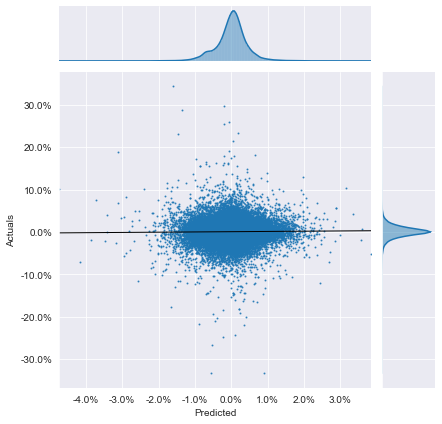

In [26]:
plot_preds_scatter(lr_predictions)

#### Daily IC Distribution

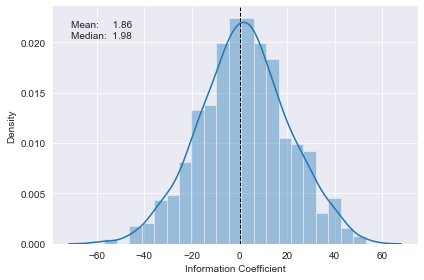

In [27]:
plot_ic_distribution(lr_scores)

#### Rolling Daily IC

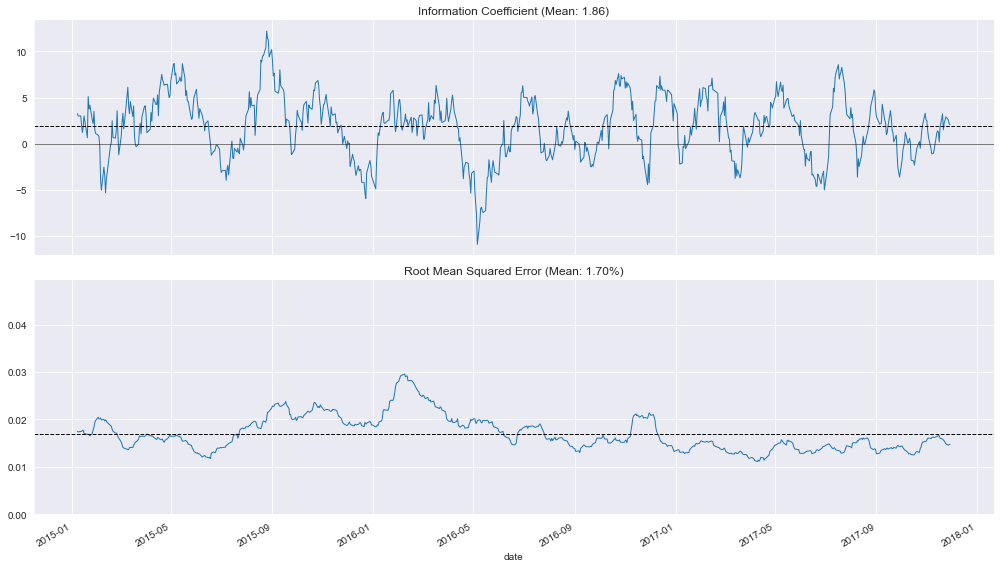

In [28]:
plot_rolling_ic(lr_scores)

## Ridge Regression

### Define cross-validation parameters

In [29]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [31]:
ridge_alphas #惩罚系数

[0.0001,
 0.0005,
 0.001,
 0.005,
 0.01,
 0.05,
 0.1,
 0.5,
 1.0,
 5.0,
 10.0,
 50.0,
 100.0,
 500.0,
 1000.0,
 5000.0,
 10000.0,
 50000.0]

In [30]:
n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation

In [32]:
target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [33]:
%%time
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas: #对数列ridge_alphas中的每一个alpha
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False, #是否计算偏置
                  random_state=42)
    #此pipe选取的model为alpha为alpha的岭回归
    pipe = Pipeline([
        ('scaler', StandardScaler()), #做岭回归需要进行标准化处理
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

Wall time: 55.7 s


### Persist results

In [34]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('data.h5', 'ridge/predictions')

In [35]:
ridge_scores = pd.read_hdf('data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('data.h5', 'ridge/predictions')

### Evaluate Ridge Results

In [36]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 1.551% (p-value: 0.0000%)


In [37]:
ridge_scores.groupby('alpha').ic.describe()
#750 = 75次循环*测试集长度10

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0005,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0010,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0050,750.0,1.863890,18.565617,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0100,750.0,1.864012,18.565426,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0500,750.0,1.864657,18.566158,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.1000,750.0,1.864743,18.566752,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.5000,750.0,1.863531,18.566137,-56.835055,-9.996599,1.966605,14.124337,53.034014
1.0000,750.0,1.863910,18.566893,-56.835055,-9.996599,1.966605,14.110091,53.161410


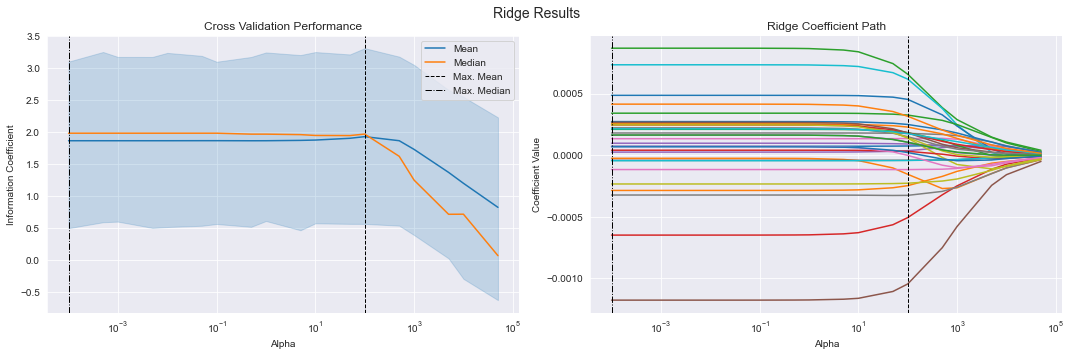

In [44]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean, #绘制一个置信区间
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')

axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

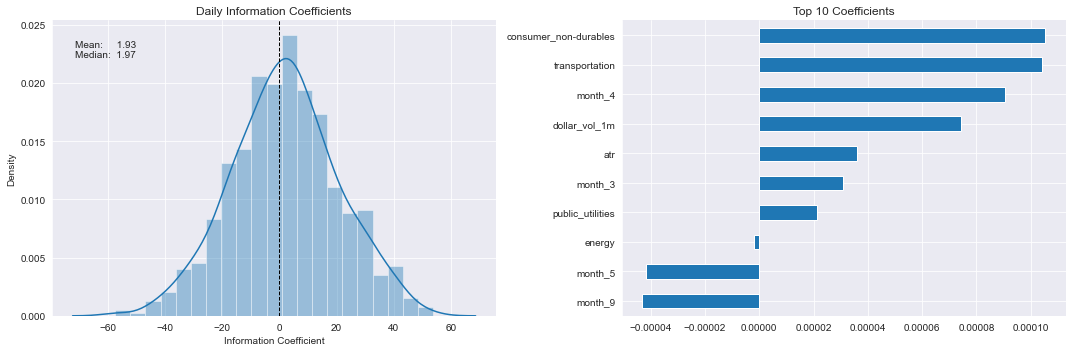

In [47]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax() #哪个alpha产生的IC均值最大，哪个alpha最好
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients') #绝对值最小的十个变量的系数
sns.despine()
fig.tight_layout()

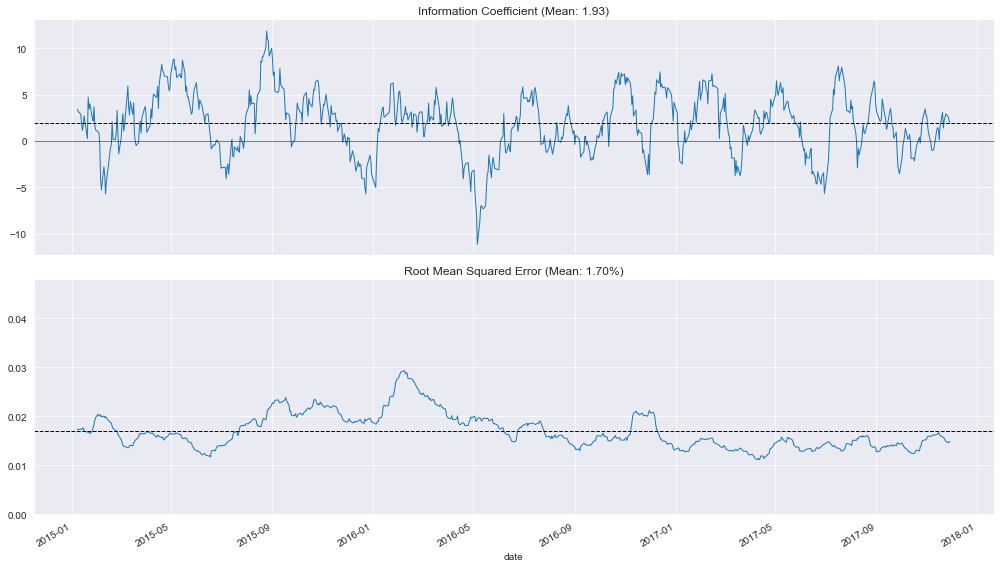

In [48]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

## Lasso CV

### Define cross-validation parameters

In [53]:
lasso_alphas = np.logspace(-10, -3, 8)
lasso_alphas

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

In [51]:
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1

In [52]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation with Lasso regression

In [54]:
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [55]:
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 Wall time: 58.4 s


### Persist results

In [56]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('data.h5', 'lasso/predictions')

### Evaluate Lasso Results

In [57]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 3.595% (p-value: 0.0000%)


In [58]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,1.863889,1.981447
1.000000e-09,1.863758,1.981447
1.000000e-08,1.864487,1.981447
1.000000e-07,1.865393,1.966605
1.000000e-06,1.875294,1.962276
1.000000e-05,1.935876,2.191108
1.000000e-04,1.575376,1.012989
1.000000e-03,1.025462,1.768092


### Lasso Coefficient Path

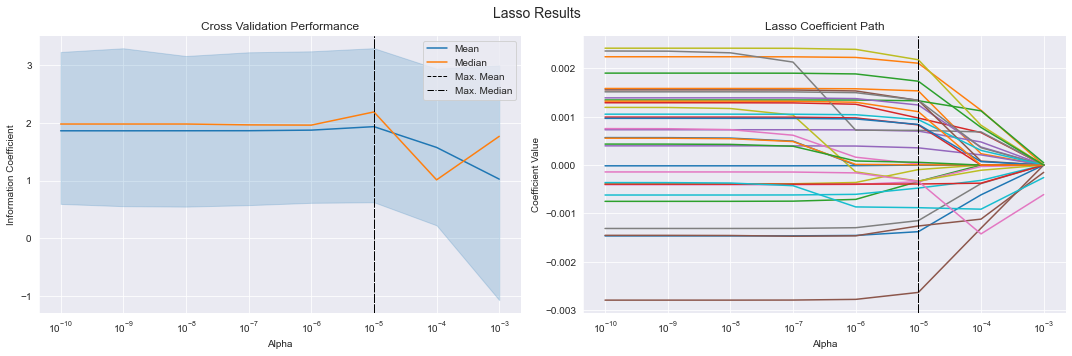

In [59]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

### Lasso IC Distribution and Top 10 Features

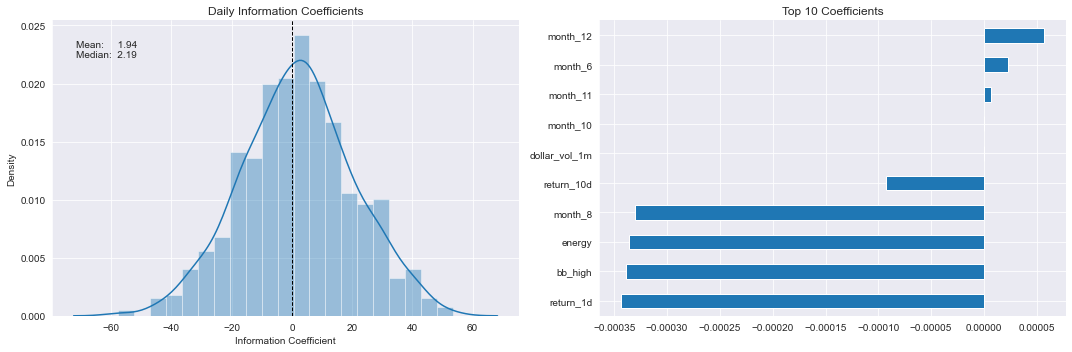

In [60]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index #top_coeffs的定义：在best_alpha的设定下，对系数取绝对值，排序，选出
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

## Compare results

In [61]:
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [62]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [63]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

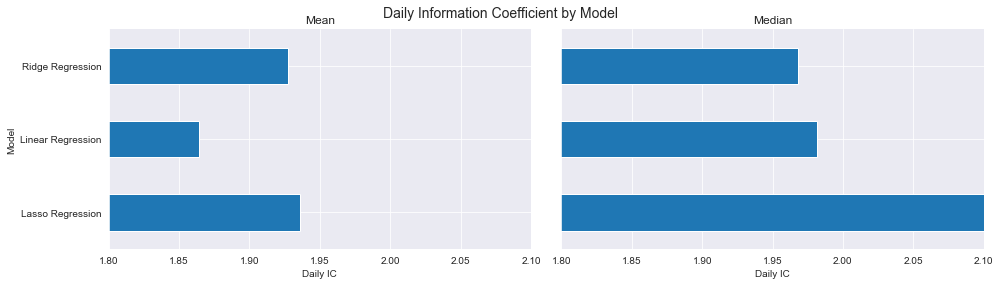

In [64]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1.85, 2), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1.8, 2.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)